# Parallel tempering with multiprocessing in Python

Parallel tempering is a Markov chain Monte carlo technique for dealing with multimodal distributions. It also improves mixing for unimodal distributions in some cases. If you are struggling to obtain convergence when sampling a posterior density and have enough compute cores to run all of your chains 
in parallel, we recommend trying parallel tempering. Parallel tempering should never be used when sampling uniform distributions.

We highly recommend using MPI for maximum performance when using parallel tempering. For examples see parallel_tempering_MPI.py or ParallelTemperingMPI.ipynb.
However, using MPI and mpi4py requires compiling hopsy with your MPI distribution.
This is because we can not assume and/or suppport all possible MPI implementations.

Instead, we provide parallel tempering using Pythons multiprocessing.
The usage is demonstrated in this notebook.

This notebook is the same as parallel_tempering_multiprocessing.py but with iPython and more comments to check whether the example works in Notebooks

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np

import hopsy

## Defining model type with multimodal density

In [2]:
class GaussianMixture:
    def __init__(self, mu1, mu2):
        epsilon = 0.05
        cov = epsilon * np.eye(2, 2)
        self.model1 = hopsy.Gaussian(mean=mu1, covariance=cov)
        self.model2 = hopsy.Gaussian(mean=mu2, covariance=cov)

    def log_density(self, x):
        return np.log(
            np.exp(-self.model1.compute_negative_log_likelihood(x))
            + np.exp(-self.model2.compute_negative_log_likelihood(x))
        )


## Setup problem and sampling configuration

In [3]:
replicates = 3
n_temps = 4
n_samples = 20_000
thinning = 10

A = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
b = np.array([1, 1, 1, 1])

model = GaussianMixture(np.ones(2).reshape(2, 1), -np.ones(2).reshape(2, 1))
problem = hopsy.Problem(A, b, model)

sync_rngs = [hopsy.RandomNumberGenerator(seed=4321 + r) for r in range(replicates)]

temperature_ladder = [1.0 - float(n) / (n_temps - 1) for n in range(n_temps)]

mcs = [
    hopsy.MarkovChain(
        proposal=hopsy.UniformCoordinateHitAndRunProposal,
        problem=problem,
        starting_point=0.9 * np.ones(2),
    )
    for r in range(replicates)
]

# Creates one parallel tempering ensemble for each replicate.
# Each ensemble will have len(temperature_ladder) chains.
chains = hopsy.create_py_parallel_tempering_ensembles(
    markov_chains=mcs,
    temperature_ladder=temperature_ladder,
    sync_rngs=sync_rngs,
    draws_per_exchange_attempt=100,
)

rngs = [hopsy.RandomNumberGenerator(i + 1234) for i, _ in enumerate(chains)]

## run and benchmark sampling

In [4]:
start = time.perf_counter()
acc_rate, samples = hopsy.sample(
    markov_chains=chains,
    rngs=rngs,
    n_samples=n_samples,
    thinning=thinning,
    n_procs=len(chains),
)
end = time.perf_counter()
print(
    f"sampling {n_samples} samples with thinning {thinning} and {len(chains)} chains took {end - start} seconds"
)

sampling 20000 samples with thinning 10 and 12 chains took 4.6743623620022845 seconds


In [5]:
## Check convergence and plot posterior marginal for first dimension

convergence check for hot samples (rhat<1.01 & ess > 400 means converged)
min ess 59333.67460630127 rhat:  1.0000329555037726
convergence check for cold samples (rhat<1.01 & ess > 400 means converged)
min ess: 2499.643044432974 , rhat:  1.0015520823985973


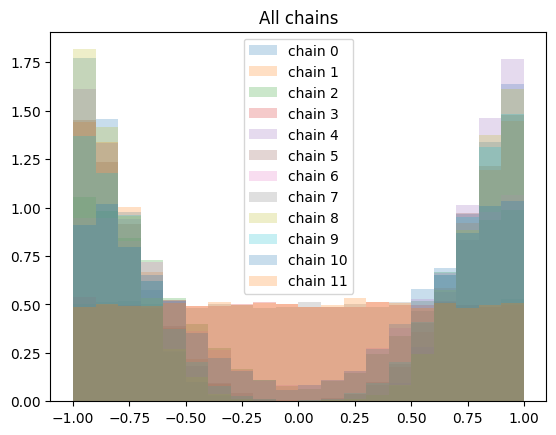

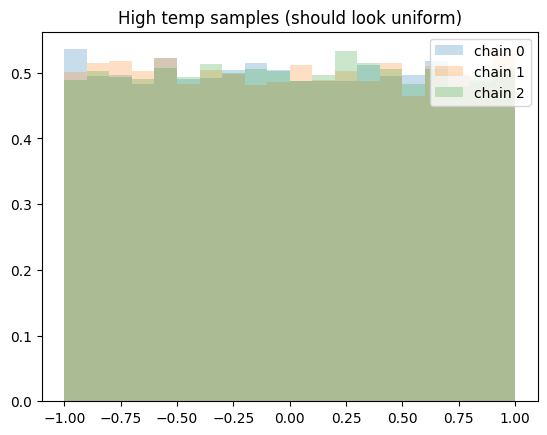

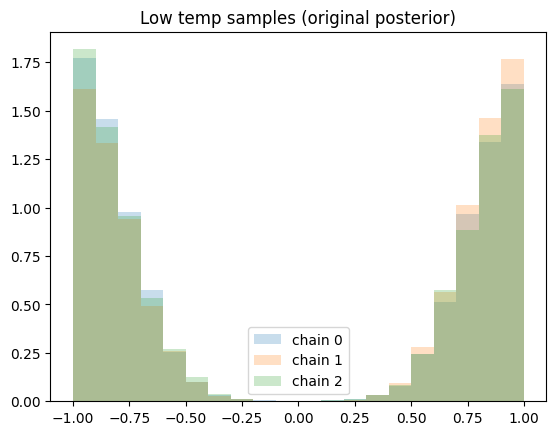

In [6]:
# plots all chains, also the tempered ones
plt.figure()
plt.title("All chains")
for i in range(samples.shape[0]):
    plt.hist(
        samples[i, :, 0], density=True, alpha=0.245, bins=20, label=f"chain {i}"
    )
plt.legend()
# DO not check convergence on all chain samples. It does not make sense, since they sampled different distributions.
# Instead, fetch all samples for a certain temp for convergence checking & plotting

# Fetches and plots the chains with the highest temperature (beta=0):
high_temp_samples = hopsy.get_samples_with_temperature(
    0, temperature_ladder, samples
)
print("convergence check for hot samples (rhat<1.01 & ess > 400 means converged)")
print(
    "min ess",
    np.min(hopsy.ess(high_temp_samples)),
    "rhat: ",
    np.max(hopsy.rhat(high_temp_samples)),
)

plt.figure()
plt.title("High temp samples (should look uniform)")
for i in range(high_temp_samples.shape[0]):
    plt.hist(
        high_temp_samples[i, :, 0],
        density=True,
        alpha=0.245,
        bins=20,
        label=f"chain {i}",
    )
plt.legend()

# Fetchs and plots the chains with the colds temperature (beta=1):
cold_temp_samples = hopsy.get_samples_with_temperature(
    1, temperature_ladder, samples
)
print("convergence check for cold samples (rhat<1.01 & ess > 400 means converged)")
print(
    "min ess:",
    np.min(hopsy.ess(cold_temp_samples)),
    ", rhat: ",
    np.max(hopsy.rhat(cold_temp_samples)),
)
plt.figure()
plt.title("Low temp samples (original posterior)")
for i in range(cold_temp_samples.shape[0]):
    plt.hist(
        cold_temp_samples[i, :, 0],
        density=True,
        alpha=0.245,
        bins=20,
        label=f"chain {i}",
    )
plt.legend()
plt.show()